# **Import Libraries**

In [1]:
pip install ml_metrics

Processing /root/.cache/pip/wheels/b3/61/2d/776be7b8a4f14c5db48c8e5451451cabc58dc6aa7ee3801163/ml_metrics-0.1.4-cp37-none-any.whl


In [2]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
from sklearn.metrics import r2_score
import ml_metrics as metrics
import numpy as np
import matplotlib.pyplot as plt


from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at /content/drive


# Download data

## Data from Kaggle

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab_data/bitstampUSD_1-min_data_2012-01-01_to_2020-12-31.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
df = df.set_index('Timestamp')

In [4]:
df.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2020-12-30 23:56:00,28801.47,28829.42,28785.64,28829.42,0.965221,27804.572129,28806.429798
2020-12-30 23:57:00,28829.42,28863.90,28829.42,28857.06,2.368831,68332.350629,28846.441863
2020-12-30 23:58:00,28850.49,28900.52,28850.49,28882.82,2.466590,71232.784464,28879.056266
2020-12-30 23:59:00,28910.54,28911.52,28867.60,28881.30,7.332773,211870.912660,28893.695831
2020-12-31 00:00:00,28893.21,28928.49,28893.21,28928.49,5.757679,166449.709320,28909.166061


## Tick data

In [36]:
df = pd.read_csv('/content/drive/MyDrive/Colab_data/bitstampUSD.csv.gz', compression='gzip')
df.rename(columns={
    "1315922016": "Timestamp",
    "5.800000000000": "Price",
    "1.000000000000": "Volume"
}, inplace=True)
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
df.set_index("Timestamp", inplace=True)

In [38]:
df['Price_by_Volume'] = df['Price'] * df['Volume']
df_vwap = df.resample('T').sum()
df_vwap['Weighted_Price'] = df_vwap['Price_by_Volume'] / df_vwap['Volume']

df_ohlc = df['Price'].resample('T').ohlc()
df_ohlc = df_ohlc.join(df_vwap[['Volume', 'Price_by_Volume', 'Weighted_Price']])

df = df_ohlc

## 1 minute data from finam.ru

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab_data/2015-2021.04.csv', index_col=0)
df["Timestamp"] = pd.to_datetime(df['Timestamp'])
df = df.set_index('Timestamp')
df.head()

### Typical price

## Calculate VWAP

In [ ]:
def np_vwap(data):
    return np.sum(data['Volume']*data['Price']) / np.sum(data['Volume'])

df_vwap = df.resample('T').apply(np_vwap)


In [ ]:
def vwap(df):
    v = df["Volume"]
    tp = (df['High'] + df['Low'] + df["Close"]) / 3
    return df.assign(vwap=(tp * v).cumsum() / v.cumsum())

# df = df.groupby(df.index.date, group_keys=False).apply(vwap)

In [ ]:
df["TP"] = (df['Close'] * df['High'] * df['Low']) / 3

In [ ]:
df.head()

In [ ]:
df.tail()

In [ ]:
def np_vwap(h, l, c, v):
    '''
    h - High
    l - Low
    v - Volume
    '''
    return np.cumsum(v*(h+l+c)/3) / np.cumsum(v)

def vwap_by_period(h, l, c, v, p):
    data = pd.Series(np.zeros(h.shape), name="My_VWAP")
    for i in range(0, h.shape[0], p):
        data[i:i+p] = np_vwap(h[i:i+p], l[i:i+p], c[i:i+p], v[i:i+p])
    return data

## Exploratory data alanysis

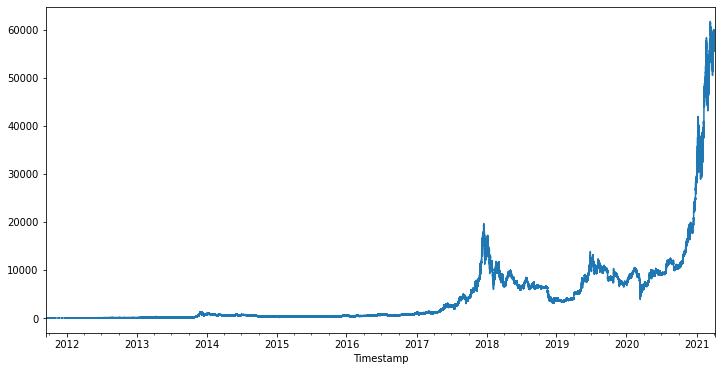

In [39]:
wp = df['Weighted_Price']
wp.plot(figsize=(12,6))

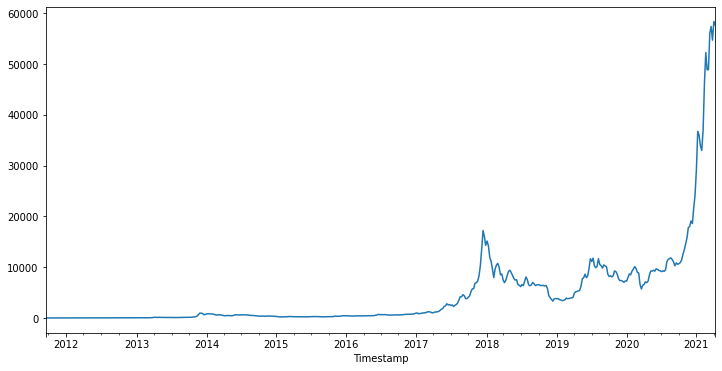

In [40]:
wp_week = wp.resample('W').mean()
wp_week.plot(figsize=(12,6))

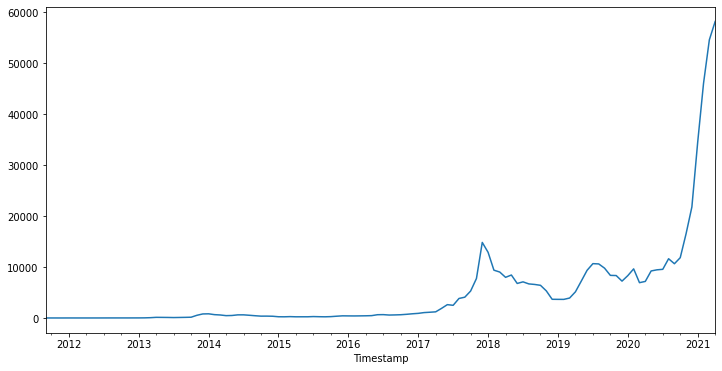

In [41]:
wp_month = df['Weighted_Price'].resample('M').mean()
wp_month.plot(figsize=(12,6))

## Normal distribution check

count      500.000000
mean      4625.188127
std       8634.783172
min          2.457414
25%        234.118444
50%        655.770757
75%       7139.933142
max      58394.451791
Name: Weighted_Price, dtype: float64

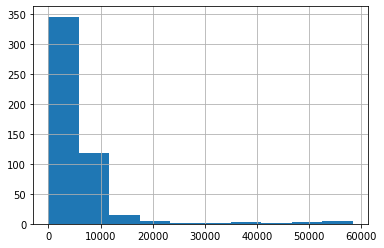

In [42]:
result = wp_week.describe()
wp_week.hist()
result

In [43]:
# Coefficient of variation
print('V = %f' % (result['std']/result['mean']))

V = 1.866904


The data is very volatile

In [44]:
row =  [u'JB', u'p-value', u'skew', u'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(wp_week)
a = np.vstack([jb_test])
result = SimpleTable(a, row)
print(result)

       JB        p-value        skew             kurtosis     
--------------------------------------------------------------
8167.65514576044     0.0 3.8944417791631625 21.203866070462478
--------------------------------------------------------------


Approving null hypotesis is 0.0%. The data is categoricaly non-normally distributed



## Dickey — Fuller test

In [45]:
def adf_test(data):
    test = sm.tsa.adfuller(data)
    print('adf: ', test[0])
    print('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print("There are unit roots, the series isn't stationary")
    else:
        print("No unit roots, the series is stationary")

In [12]:
adf_test(wp_week)

adf:  1.552303318614339
p-value:  0.9977071868380033
Critical values:  {'1%': -3.444583778100581, '5%': -2.8678163032301995, '10%': -2.570113030490433}
There are unit roots, the series isn't stationary


In [13]:
wp_week_1diff = wp_week.diff(periods=1).dropna()
adf_test(wp_week_1diff)

adf:  -2.6299541461566003
p-value:  0.08696302483408697
Critical values:  {'1%': -3.444932949082776, '5%': -2.867969899953726, '10%': -2.57019489663276}
There are unit roots, the series isn't stationary


In [14]:
wp_week_2diff = wp_week.diff(periods=2).dropna()
adf_test(wp_week_2diff)

adf:  -2.158865630775791
p-value:  0.2215119858446044
Critical values:  {'1%': -3.444965543297668, '5%': -2.8679842369272976, '10%': -2.5702025382716047}
There are unit roots, the series isn't stationary


In [15]:
wp_week_3diff = wp_week.diff(periods=3).dropna()
adf_test(wp_week_3diff)

adf:  -2.2789872093039123
p-value:  0.178834592100777
Critical values:  {'1%': -3.444965543297668, '5%': -2.8679842369272976, '10%': -2.5702025382716047}
There are unit roots, the series isn't stationary


In [16]:
wp_week_4diff = wp_week.diff(periods=4).dropna()
adf_test(wp_week_4diff)

adf:  -2.676494033278248
p-value:  0.0781948975324524
Critical values:  {'1%': -3.4450311708077743, '5%': -2.8680131035505023, '10%': -2.570217924306441}
There are unit roots, the series isn't stationary


In [17]:
wp_week_5diff = wp_week.diff(periods=5).dropna()
adf_test(wp_week_5diff)

adf:  -2.9128301388168736
p-value:  0.043876240286448466
Critical values:  {'1%': -3.4450642060791097, '5%': -2.868027634065253, '10%': -2.5702256691640515}
No unit roots, the series is stationary


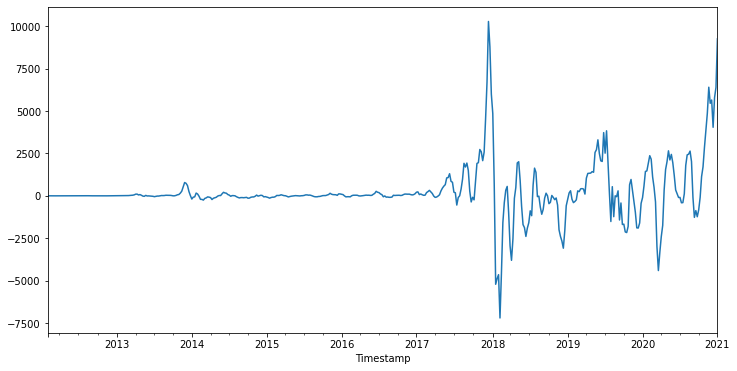

In [18]:
wp_week_5diff.plot(figsize=(12,6))

The series is integrated series with 5th order.

# Build ARMA, ARIMA and SARIMAX models

## ACF and PACF

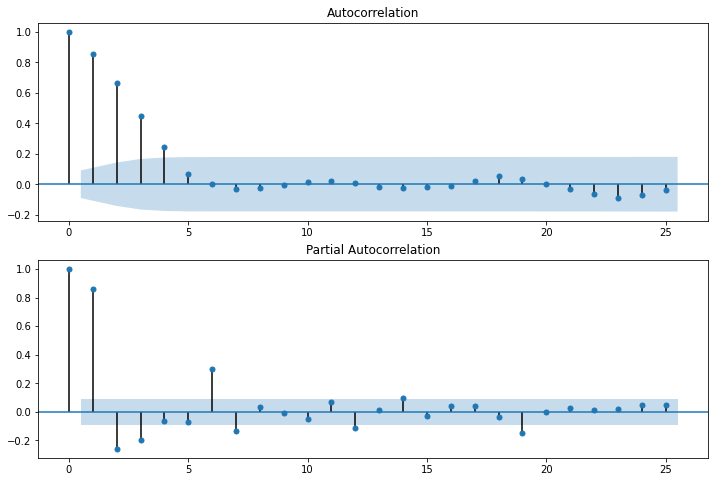

In [19]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(wp_week_5diff.values.squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(wp_week_5diff, lags=25, ax=ax2)

AR = 6,7,19 (p)  
D = 5  
MA = 5

## Build ARMA model

In [20]:
src_data_model = wp_week[:'2019-12-29']
model = sm.tsa.ARMA(src_data_model, order=(19, 5), freq='W').fit(full_output=False, disp=0)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(2609.0, 2632.0)

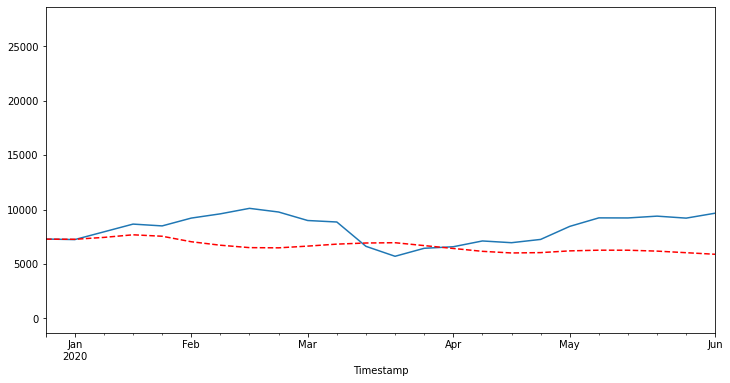

In [32]:
pred = model.predict(start=wp_week.index[0], end=wp_week.index[-1])
wp_week.plot(figsize=(12,6))
plt.xlim('2019-12-29', '2020-01-24')
pred.plot(style='r--')
plt.xlim('2019-12-29', '2020-06-01')


In [ ]:
src_data_model = wp_week[:'2019-12-29']
model = sm.tsa.ARMA(src_data_model, order=(19,4), freq='W').fit(full_output=False, disp=0)

In [ ]:
pred = model.predict(start='2017-12-29', end='2021-01-03')
trn = wp_week['2019-12-29':]
wp_week.plot(figsize=(12,6))
pred.plot(style='r--')

ARIMA don't support series with the order more than 2. Need to use SARIMAX. But let's try to use ARIMA with d = 2. And see what it will be. 

ARIMA gave a prediction error: KeyError: '2019-12-31'
dropna didn't help.
Tried floor to month

In [35]:
src_data_model = wp_month[:'2019-12-31']
model = sm.tsa.SARIMAX(src_data_model, order=(19,5,5), freq='M').fit(full_output=False, disp=0)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [ ]:
print(model.summary())

In [ ]:
pred = model.predict(start='2019-12-31', end='2020-12-31')
trn = wp_month['2019-12-31':]
r2 = r2_score(trn, pred)
print('R^2: %1.2f' % r2)

In [ ]:
metrics.rmse(trn,pred[0:13])

In [ ]:
metrics.mae(trn,pred[0:13])

In [ ]:
wp_month.plot(figsize=(12,6))
pred.plot(style='r--')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


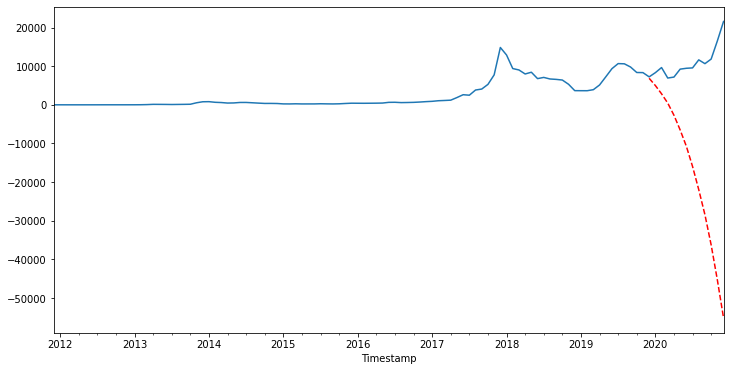

In [34]:
src_data_model = wp_month[:'2019-12-31']
model = sm.tsa.SARIMAX(src_data_model, order=(6,5,4), freq='M', trend=).fit(full_output=False, disp=0)
pred = model.predict(start='2019-12-31', end='2020-12-31')
trn = wp_month['2019-12-31':]
wp_month.plot(figsize=(12,6))
pred.plot(style='r--')

In [ ]:
src_data_model = wp_week[:'2019-12-29']
model = sm.tsa.SARIMAX(src_data_model, order=(5,5,6), freq='W').fit(full_output=False, disp=0)

In [ ]:
pred = model.predict(start='2019-12-29', end='2021-01-03')
wp_week.plot(figsize=(12,6))
pred.plot(style='r--')

In [ ]:
src_data_model = wp.resample('H').mean()[:'2019-12-29']
model = sm.tsa.SARIMAX(src_data_model, order=(5,5,6)).fit(full_output=False, disp=0)

In [ ]:
trn = wp.resample('H').mean()[:'2019-12-29']
wp.resample('H').mean().plot(figsize=(12,6))
pred.plot(style='r--')

# Build ARCH, GARCH models

## Import libraries for ARCH

In [ ]:
pip install arch

In [ ]:
from arch import arch_model

## ARCH

In [ ]:
m_train, m_test = wp_month[:'2019-12-29'], wp_month['2019-12-29':]

In [ ]:
model = arch_model(m_train, mean='constant', vol='ARCH', p=5)
model_fit = model.fit()
forecast = model_fit.forecast(start='2019-12-29', horizon=11)

In [ ]:
wp_month.plot(figsize=(12,6))
forecast.mean.plot(style='r--')